# ДОМАШНЕЕ ЗАДАНИЕ - 1

## Практическое задание

<ol>
    <li>Попробуйте видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом, чтобы улучшить ее точность. Проведите анализ — что приводит к ухудшению точности нейронной сети? Что приводит к увеличению ее точности?</li>
</ol>

# Введение в искусственные нейронные сети
# Урок 1. Основы обучения нейронных сетей

## Пример построения  двухслойной нейронной сети на numpy

In [1]:
'''
Исходный код к уроку 1.
Построение двухслойной нейронный сети для классификации цветков ириса
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore')

# sklearn здесь только, чтобы разделить выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split


### Шаг 1. Определение функций, которые понадобяться для обучения
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = layer2[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# сигмоида и ее производная
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x)*(1 - sigmoid(x))

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)


### Шаг 2. Подготовка тренировочных данных
# получения данных из csv файла. укажите здесь путь к файлу Iris.csv
iris_data = pd.read_csv("Iris.csv")


# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
x = normalize(x.values)

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
y = y.values
y = y.flatten()
y = to_one_hot(y).argmax(axis=1)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [2]:
from sklearn.base import BaseEstimator

class NN(BaseEstimator):
    def __init__(self, iters=1, learning_rate=1):
        self.iters = iters
        self.learning_rate = learning_rate
        self.w0 = 2*np.random.random((4, 5))
        self.w1 = 2*np.random.random((5, 3))     
        

    def fit(self, X_train, y_train):
        
        self.errors = []
        y_train = to_one_hot(y_train)
        
        for i in range(int(self.iters)):
        
            # прямое распространение(feed forward)
            layer0 = X_train
            layer1 = sigmoid(np.dot(layer0, self.w0))
            layer2 = sigmoid(np.dot(layer1, self.w1))
        
            # обратное распространение(back propagation) с использованиемd градиентного спуска
            layer2_error = y_train - layer2
            layer2_delta = layer2_error * sigmoid_deriv(layer2)
            
            layer1_error = layer2_delta.dot(self.w1.T)
            layer1_delta = layer1_error * sigmoid_deriv(layer1)
            
            self.w1 += layer1.T.dot(layer2_delta) * self.learning_rate
            self.w0 += layer0.T.dot(layer1_delta) * self.learning_rate
            
            error = np.mean(np.abs(layer2_error))
            self.errors.append(error)
    
    
    def predict(self, X_test):
        layer0 = X_test
        layer1 = sigmoid(np.dot(layer0, self.w0))
        layer2 = sigmoid(np.dot(layer1, self.w1))
        return layer2.argmax(axis=1)
    
    # score - accuracy
    def score(self, x, y):
        layer0 = x
        layer1 = sigmoid(np.dot(layer0, self.w0))
        layer2 = sigmoid(np.dot(layer1, self.w1))
        layer2_error = to_one_hot(y) - layer2
        error = np.mean(np.abs(layer2_error))
        accuracy = (1 - error) * 100
        return accuracy

In [3]:
from sklearn.model_selection import cross_val_score, ShuffleSplit 
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
result = []

# сетка параметров
rate_space = np.logspace(-3, 0, 4)
iters_space = np.linspace(1000,10000,5).astype(int)

# кросс-валидатор
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

# счетчик для отображения прогресса
counter_len = len(rate_space)*len(iters_space)
counter = 0


for learning_rate in rate_space:
    for iters in iters_space:
        
        # отображение прогесса вычислений
        counter += 1
        print(f'{counter}/{counter_len} ({counter*100/counter_len:.1f}%)', end='\r')
        
        # средний скор на кросс-валидации (score - accuracy)
        mean_accuracy = cross_val_score(NN(iters, learning_rate), x, y, cv=cv).mean()
        
        # накопление резульатов
        result.append([learning_rate,iters, mean_accuracy])

Лучшие оценки

In [5]:
pd.DataFrame(result, columns=['learning rate','iters','accuracy']).sort_values('accuracy',ascending=False).head(3)

,learning rate,iters,accuracy
12,0.1,5500,96.808199
14,0.1,10000,96.730844
13,0.1,7750,96.715437


Обучение на лучших параметрах

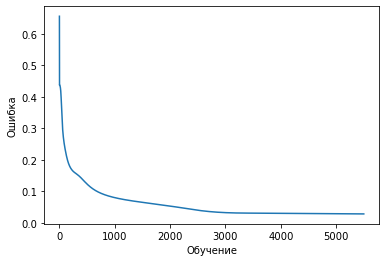

In [9]:
best_clf = NN(iters=5500, learning_rate=0.1)
best_clf.fit(X_train, y_train)

# Демонстрация ошибки во время обучения
plt.plot(best_clf.errors)
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show() 

Отчет по классификации

In [10]:
y_pred = best_clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.86      1.00      0.92        12
           2       1.00      0.88      0.93        16

    accuracy                           0.96        50
   macro avg       0.95      0.96      0.95        50
weighted avg       0.97      0.96      0.96        50



Матрица смежности

In [11]:
print(confusion_matrix(y_test,y_pred))

[[22  0  0]
 [ 0 12  0]
 [ 0  2 14]]


C увеличением количества итераций растет точность. Learning_rate - скорость, с которой происходит обучение. То есть, чем меньше learning rate, тем больше итераций нужно затратить, чтоб минимизировать ошибку. Но в то же время, точность, увеличивается. Оптимальное значение learning rate позволяет достичь минимальной ошибки за наименьшее число итераций.